In [6]:
% matplotlib inline
import sys
#sys.path.append('/home/ubuntu/caffe/python/')
import caffe
from caffe import layers as L, params as P, to_proto
from caffe.proto import caffe_pb2
import numpy as np
import matplotlib as plt

In [7]:
def conv_relu(bottom, ks, nout, stride=1, pad=0, group=1):
    conv = L.Convolution(bottom, kernel_size=ks, stride=stride,
                                num_output=nout, pad=pad, group=group)
    return conv, L.ReLU(conv, in_place=True)

def fc_relu(bottom, nout):
    fc = L.InnerProduct(bottom, num_output=nout)
    return fc, L.ReLU(fc, in_place=True)

def max_pool(bottom, ks, stride=1):
    return L.Pooling(bottom, pool=P.Pooling.MAX, kernel_size=ks, stride=stride)

def caffenet(lmdb, batch_size=256, include_acc=False):
    data, label = L.Data(source=lmdb, backend=P.Data.LMDB, batch_size=batch_size, ntop=2,
        transform_param=dict(crop_size=227, mean_value=[104, 117, 123], mirror=True))

    # the net itself
    conv1, relu1 = conv_relu(data, 11, 96, stride=4)
    pool1 = max_pool(relu1, 3, stride=2)
    norm1 = L.LRN(pool1, local_size=5, alpha=1e-4, beta=0.75)
    conv2, relu2 = conv_relu(norm1, 5, 256, pad=2, group=2)
    pool2 = max_pool(relu2, 3, stride=2)
    norm2 = L.LRN(pool2, local_size=5, alpha=1e-4, beta=0.75)
    conv3, relu3 = conv_relu(norm2, 3, 384, pad=1)
    conv4, relu4 = conv_relu(relu3, 3, 384, pad=1, group=2)
    conv5, relu5 = conv_relu(relu4, 3, 256, pad=1, group=2)
    pool5 = max_pool(relu5, 3, stride=2)
    fc6, relu6 = fc_relu(pool5, 4096)
    drop6 = L.Dropout(relu6, in_place=True)
    fc7, relu7 = fc_relu(drop6, 4096)
    drop7 = L.Dropout(relu7, in_place=True)
    fc8 = L.InnerProduct(drop7, num_output=1000)
    loss = L.SoftmaxWithLoss(fc8, label)

    if include_acc:
        acc = L.Accuracy(fc8, label)
        return to_proto(loss, acc)
    else:
        return to_proto(loss)
    
caffenet('data/cifar100-dtrain')

In [8]:
caffe.set_device(0)
caffe.set_mode_gpu()


In [9]:
!pwd

/home/ubuntu/hw3


In [10]:
solver = caffe.SGDSolver('q3/solver.prototxt')

In [11]:
[(k, v.data.shape) for k, v in solver.net.blobs.items()]

[('data', (100, 3, 32, 32)),
 ('label', (100,)),
 ('label_cifar_1_split_0', (100,)),
 ('label_cifar_1_split_1', (100,)),
 ('conv1', (100, 64, 30, 30)),
 ('relu1', (100, 64, 30, 30)),
 ('pool1', (100, 64, 30, 30)),
 ('conv2', (100, 32, 30, 30)),
 ('relu2', (100, 32, 30, 30)),
 ('pool2', (100, 32, 30, 30)),
 ('drop2', (100, 32, 30, 30)),
 ('conv3', (100, 16, 31, 31)),
 ('relu3', (100, 16, 31, 31)),
 ('pool3', (100, 16, 31, 31)),
 ('drop3', (100, 16, 31, 31)),
 ('fc1', (100, 768)),
 ('fc2', (100, 100)),
 ('fc2_fc2_0_split_0', (100, 100)),
 ('fc2_fc2_0_split_1', (100, 100)),
 ('accuracy', ()),
 ('loss', ())]

In [12]:

solver.net.forward()  # train net
solver.test_nets[0].forward()  # test net (there can be more than one)

{'accuracy': array(0.009999999776482582, dtype=float32),
 'loss': array(4.61062479019165, dtype=float32)}

In [ ]:
%%time
niter = 30000
test_interval = 1000
# losses will also be stored in the log
train_loss = np.zeros(niter)
test_acc = np.zeros(int(np.ceil(niter / test_interval)))
output = np.zeros((niter, 8, 10))

# the main solver loop
for it in range(niter):
    solver.step(1)  # SGD by Caffe
    
    # store the train loss
    train_loss[it] = solver.net.blobs['loss'].data
    
    # store the output on the first test batch
    # (start the forward pass at conv1 to avoid loading new data)
    solver.test_nets[0].forward(start='conv1')
    #output[it] = solver.test_nets[0].blobs['ip2'].data[:8]
    
    # run a full test every so often
    # (Caffe can also do this for us and write to a log, but we show here
    #  how to do it directly in Python, where more complicated things are easier.)
    if it % test_interval == 0:
        print 'Iteration', it, 'testing...'
        correct = 0
        for test_it in range(100):
            solver.test_nets[0].forward()
            correct += sum(solver.test_nets[0].blobs['fc2'].data.argmax(1)
                           == solver.test_nets[0].blobs['label'].data)
        test_acc[it / test_interval] = correct / 1e4

Iteration 0 testing...
Iteration

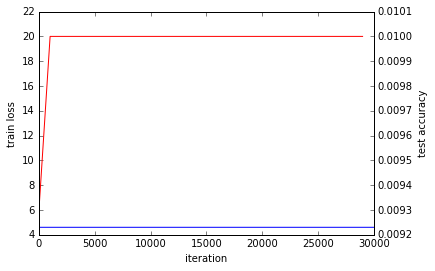

In [14]:
_, ax1 = plt.pyplot.subplots()
ax2 = ax1.twinx()
ax1.plot(np.arange(niter), train_loss)
ax2.plot(test_interval * np.arange(len(test_acc)), test_acc, 'r')
ax1.set_xlabel('iteration')
ax1.set_ylabel('train loss')
ax2.set_ylabel('test accuracy')

In [46]:
train_loss

array([ 4.60517931,  4.60546017,  4.60468102, ...,  4.6051569 ,
        4.60521221,  4.60518932])

array(4.605189323425293, dtype=float32)